In [1]:
import numpy as np


slice_ind = slice

def slice(input, begin, size):
    """
    Slice an array using a iterable start and length vector
    :param input: Input array to be sliced
    :param begin: Vector of indices where to start slicing
    :param size: Vector of slice lengths
    :return: Sliced array
    """

    slices = tuple(slice_ind(b, b + s) for b, s in zip(begin, size))
    return input[slices]


def batch_gather(params, indices, axis):
    """
    Gather slices from `params` according to `indices` with leading batch dims.
    This operation assumes that the leading dimensions of `indices` are dense,
    and the gathers on the axis corresponding to the last dimension of `indices`.
    More concretely it computes:
    `result[i1, ..., in, j1, ..., jm, k1, ...., kl] = params[i1, ..., in, indices[i1, ..., in, j1, ..., jm], k1, ..., kl]`
    Therefore `params` should be a Tensor of shape [A1, ..., AN, C0, B1, ..., BM],
    `indices` should be a Tensor of shape [A1, ..., AN, C1, ..., CK] and `result` will be
    a Tensor of size `[A1, ..., AN, C1, ..., CK, B1, ..., BM]`.
    Args:
      params: The array from which to gather values.
      indices: Must be one of the following types: int32, int64. Index
          array. Must be in range `[0, params.shape[axis]`, where `axis` is the
          last dimension of `indices` itself.
      axis: Must be one of the following types: int32, int64. The axis
            in `params` to gather `indices` from.
    Returns:
      An array. Has the same type as `params`.
    """

    indices_shape = indices.shape
    params_shape = params.shape
    ndim = indices.ndim
    indices_internal = indices.copy()

    # Adapt indices to act on respective batch
    accum_dim_value = 1
    for dim in range(axis, 0, -1):
        dim_value = params_shape[dim - 1]
        accum_dim_value *= params_shape[dim]
        dim_indices = np.arange(dim_value)
        dim_indices *= accum_dim_value
        dim_shape = [1] * (dim - 1) + [dim_value] + [1] * (ndim - dim)
        indices_internal += dim_indices.reshape(*dim_shape)

    flat_inner_shape_indices = np.prod(indices_shape[:(axis + 1)])
    flat_indices = indices_internal.reshape(*((flat_inner_shape_indices,) + indices_shape[(axis + 1):]))
    outer_shape = params_shape[(axis + 1):]
    flat_inner_shape_params = np.prod(params_shape[:(axis + 1)])

    flat_params = params.reshape(*((flat_inner_shape_params,) + outer_shape))
    flat_result = flat_params[flat_indices,...]
    result = flat_result.reshape(*(indices_shape + outer_shape))
    return result


def batch_histogram(values, value_range, axis, nbins=100, use_map=False):
    """
    Computes histogram with fixed width considering batch dimensions
    :param values: Array containing the values for histogram computation.
    :param value_range: Shape [2] iterable. values <= value_range[0] will be mapped to
    hist[0], values >= value_range[1] will be mapped to hist[-1].
    :param axis: Number of batch dimensions. First axis to apply histogram computation to.
    :param nbins: Scalar. Number of histogram bins.
    :param use_map: Flag indicating whether map function is used
    :return: histogram with batch dimensions.
    """

    # Get shape
    values_shape = values.shape
    batch_dim = values_shape[:axis]
    outer_dim = values_shape[axis:]
    num_batch = np.prod(batch_dim)

    if use_map:
        values_reshaped = values.reshape(*((num_batch,) + outer_dim))
        hist = np.array(list(map(lambda x: np.histogram(x, range=value_range, bins=nbins)[0], values_reshaped)))
    else:
        # Normalize
        values_double = values.astype('double')
        value_range_double = np.array(value_range).astype('double')

        # Clip values
        values_norm = (values_double - value_range_double[0]) / (value_range_double[1] - value_range_double[0])
        values_clip1 = np.maximum(values_norm, 0.5 / nbins)
        values_clip2 = np.minimum(values_clip1, 1.0 - 0.5 / nbins)

        # Shift values
        values_shift = values_clip2 + np.arange(num_batch).reshape(*(batch_dim + len(outer_dim) * (1,)))

        # Get histogram
        hist = np.histogram(values_shift, range=[0, num_batch], bins=num_batch * nbins)[0]

    return hist.reshape(*(batch_dim + (nbins,)))

In [11]:
import numpy as np
from itertools import product

def mclahe(x, kernel_size=None, n_bins=128, clip_limit=0.01, adaptive_hist_range=False):
    """
    Contrast limited adaptive histogram equalization
    :param x: numpy array to which clahe is applied
    :param kernel_size: tuple of kernel sizes, 1/8 of dimension lengths of x if None
    :param n_bins: number of bins to be used in the histogram
    :param clip_limit: relative intensity limit to be ignored in the histogram equalization
    :param adaptive_hist_range: flag, if true individual range for histogram computation of each block is used
    :return: numpy array to which clahe was applied, scaled on interval [0, 1]
    """

    if kernel_size is None:
        kernel_size = tuple(s // 8 for s in x.shape)
    kernel_size = np.array(kernel_size)

    assert len(kernel_size) == len(x.shape)

    dim = len(x.shape)

    # Normalize data
    x_min = np.min(x)
    x_max = np.max(x)
    x = (x - x_min) / (x_max - x_min)

    # Pad data
    x_shape = np.array(x.shape)
    padding_x_length = kernel_size - 1 - ((x_shape - 1) % kernel_size)
    padding_x = np.column_stack(((padding_x_length + 1) // 2, padding_x_length // 2))
    padding_hist = np.column_stack((kernel_size // 2, (kernel_size + 1) // 2)) + padding_x
    x_hist_padded = np.pad(x, padding_hist, 'symmetric')

    x_padded = slice(x_hist_padded, kernel_size // 2, x_shape + padding_x_length)

    # Form blocks used for interpolation
    n_blocks = np.ceil(np.array(x.shape) / kernel_size).astype(np.int32)
    new_shape = np.reshape(np.column_stack((n_blocks, kernel_size)), (2 * dim,))
    perm = tuple(2 * i for i in range(dim)) + tuple(2 * i + 1 for i in range(dim))
    x_block = np.transpose(x_padded.reshape(*new_shape), perm)
    shape_x_block = np.concatenate((n_blocks, kernel_size))

    # Form block used for histogram
    n_blocks_hist = n_blocks + np.ones(dim, dtype=np.int32)
    new_shape = np.reshape(np.column_stack((n_blocks_hist, kernel_size)), (2 * dim,))
    perm = tuple(2 * i for i in range(dim)) + tuple(2 * i + 1 for i in range(dim))
    x_hist = np.transpose(x_hist_padded.reshape(*new_shape), perm)

    # Get maps
    # Get histogram
    if adaptive_hist_range:
        hist_ex_shape = np.concatenate((n_blocks_hist, [1] * dim))
        x_hist_max = np.max(x_hist, tuple(np.arange(-dim, 0)))
        x_hist_min = np.min(x_hist, tuple(np.arange(-dim, 0)))
        x_hist_norm = np.where(x_hist_min == x_hist_max, np.ones_like(x_hist_min), x_hist_max - x_hist_min)

        x_hist_scaled = (x_hist - x_hist_min.reshape(*hist_ex_shape)) / x_hist_norm.reshape(*hist_ex_shape)
    else:
        x_hist_scaled = x_hist
    hist = batch_histogram(x_hist_scaled, [0., 1.], dim, nbins=n_bins).astype(np.float32)
    # Clip histogram
    n_to_high = np.sum(np.maximum(hist - np.prod(kernel_size) * clip_limit, 0), -1, keepdims=True)
    hist_clipped = np.minimum(hist, np.prod(kernel_size) * clip_limit) + n_to_high / n_bins
    cdf = np.cumsum(hist_clipped, -1)
    cdf_min = cdf[..., :1]
    cdf_max = cdf[..., -1:]
    cdf_norm = np.where(cdf_min == cdf_max, np.ones_like(cdf_max), cdf_max - cdf_min)
    mapping = (cdf - cdf_min) / cdf_norm

    # Get global hist bins if needed
    # Compute always as they are needed for both modes
    bin_edges = np.histogram_bin_edges(x_hist_scaled, range=[0., 1.], bins=n_bins)[1:-1]
    if not adaptive_hist_range:
        # Global bins
        bin_ind = np.digitize(x_block, bin_edges)

    # Loop over maps to compute result
    res = np.zeros(shape_x_block)
    inds = [list(i) for i in product([0, 1], repeat=dim)]
    for ind_map in inds:
        # Compute bin indices if local bins are used
        if adaptive_hist_range:
            # Local bins
            hist_norm_slice_shape = np.concatenate((n_blocks, [1] * dim))
            x_hist_min_sub = slice(x_hist_min, ind_map, n_blocks)
            x_hist_norm_sub = slice(x_hist_norm, ind_map, n_blocks)
            x_block_scaled = (x_block - x_hist_min_sub.reshape(*hist_norm_slice_shape)) \
                             / x_hist_norm_sub.reshape(*hist_norm_slice_shape)
            bin_ind = np.digitize(x_block_scaled, bin_edges)
        
        # Apply map
        map_slice = slice(mapping, ind_map + [0], list(n_blocks) + [n_bins])
        mapped_sub = batch_gather(map_slice, bin_ind, dim)

        # Calculate and apply coefficients
        res_sub = mapped_sub
        for axis in range(dim):
            coeff = np.arange(kernel_size[axis], dtype=np.float32) / kernel_size[axis]
            if kernel_size[axis] % 2 == 0:
                coeff = 0.5 / kernel_size[axis] + coeff
            if ind_map[axis] == 0:
                coeff = 1. - coeff
            new_shape = [1] * (dim + axis) + [kernel_size[axis]] + [1] * (dim - 1 - axis)
            coeff = np.reshape(coeff, new_shape)
            res_sub = coeff * res_sub

        # Update results
        res = res + res_sub

    # Rescaling
    res_min, res_max = (np.min(res), np.max(res))
    res_norm = (res - res_min) / (res_max - res_min)

    # Reshape result
    new_shape = tuple((axis, axis + dim) for axis in range(dim))
    new_shape = tuple(j for i in new_shape for j in i)
    res_transposed = np.transpose(res_norm, new_shape)
    res_reshaped = res_transposed.reshape(*tuple(n_blocks[axis] * kernel_size[axis] for axis in range(dim)))

    # Recover original size
    result = slice(res_reshaped, padding_x[:, 0], x.shape)

    return result

In [4]:
def clahe_3d(voxel):
    voxel = mclahe(voxel, kernel_size=[8,32,32],
              n_bins=128,
              clip_limit=0.01,
              adaptive_hist_range=False)
    return (voxel*255.).astype(np.uint8).clip(0, 255)

In [5]:
import matplotlib.pyplot as plt

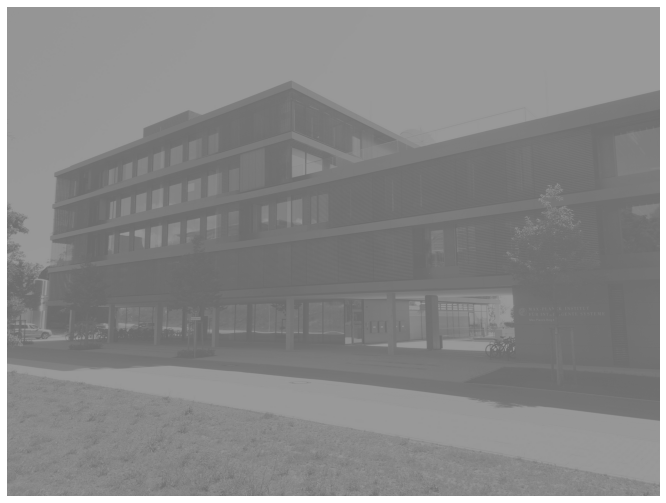

In [9]:
# Load and show image with bad contrast
img = plt.imread('example_2d.jpg')
plt.figure(figsize=(12, 9))
plt.imshow(img)
plt.axis('off')
plt.show()

In [12]:
# Apply mclahe
img_mclahe = mclahe(img[:, :, 0])

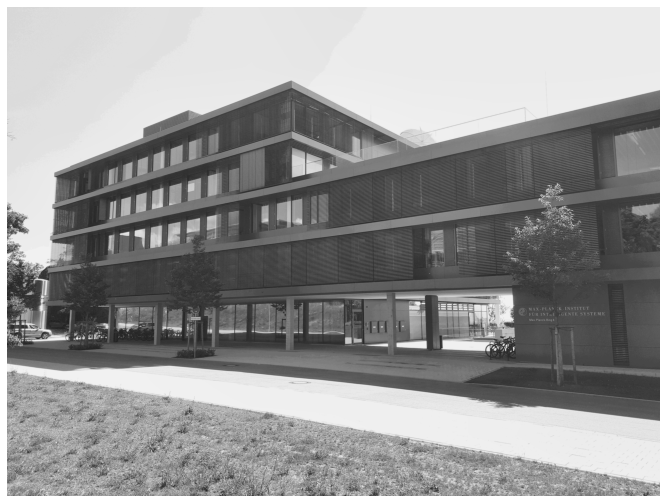

In [13]:
# Show result
plt.figure(figsize=(12, 9))
plt.imshow(np.tile(np.expand_dims(img_mclahe, 2), (1, 1, 3)))
plt.axis('off')
plt.show()